# 2D Water Waves using Julia
Gravity waves in water follow a perhaps enigmatic dispersion relation. The phase speed $c_p$ is given by
$$
c_p^2 = \left(\frac{\omega}{k} \right)^2 = \frac{g}{k} \tanh (kd),
$$
where $g$ is the acceleration of gravity and $d$ is the water depth. This relation captures subsurface hydrodynamics that are not reducible to a wave equation of finite order for the water surface $z(x,y,t)$. However, given the dispersion relation, an efficient model of linear wave evolution may be implemented using the fast Fourier transform (FFT).

## Linear waves in 2D

Homogeneous Neumann boundary conditions on a square “lake” of width $W$ is satisfied by decomposing the instantaneous waveform as a cosine series, 
$$
    z(x,y) = \sum_{m,n} \tilde{z}_{m,n} \cos(k_xx) \cos(k_yy).
$$
Each mode is indexed by quantum numbers $m,n \in \{ 1,2,3,...N\}$. The choice of some finite $N$ specifies the resolution of our model, $N\times N$ sampling on domain $x,y \in [0,W]$.
The allowed wavenumbers are, e.g.,
$$
    k_x = \frac{m π}{W},
$$
and similarly for $k_y$, which is indexed by $n$. Coefficients $\tilde{z}_{m,n}$ are readily obtained for an arbitrary surface waveform $z(x,y)$ by the 2D discrete cosine transform (DCT), which is provided by typical FFT libraries. 

The time dependence of each mode $(m,n)$ is independent of the rest. It enters through the DCT coefficients, 
$$
    \tilde{z}_{m,n}(t) = A_{m,n} \cos(\omega t + \varphi_{m,n}),   \quad(1)
$$
where $A_{m,n}$ is the scalar amplitude in meters for mode $(m,n)$. The frequency $\omega$ also depends on $(m,n)$. In terms of the scalar wavenumber 
$$
    k \equiv \sqrt{k_x^2+k_y^2} = \frac{\pi}{W}\sqrt{m^2 + n^2}\,,
$$
the frequency is given by solving the water wave dispersion relation to obtain
$$
    \omega = \sqrt{ gk\,\tanh(kd) }.
$$
We require only the positive square root (positive frequency) because the phase is captured explicitly by $\varphi_{m,n}$.

### Initial conditions
The entire past and futuere time development of an isolated, linear, undamped lake is determined if the state of the system is given at a single time $t=t_1$. The state may be fully specified by two real constants (the value and time derivative of the coefficient) for each mode $(m,n)$:
$$
    \tilde{z}_{m,n}(t_1) = \tilde{z}_{1,m,n}; \quad 
    \dot{\tilde{z}}_{m,n}(t_1) = \tilde{v}_{1,m,n}.
$$
The time dependence $\tilde{z}_{m,n}$ merely requires a sinusoid of frequency $\omega_k$ obeying the above two boundary conditions:
$$
    \boxed{\tilde{z}_{m,n}(t) = 
        \tilde{z}_{1,m,n} \cos\left[ \omega (t-t_1) \right] +
        \frac{\tilde{v}_{1,m,n}}{\omega} \sin\left[ \omega (t-t_1) \right]
        \quad(2)}
$$
The above formulation is probably the most convenient for implementation. To recover equation (1), we can squeeze it all into a cosine by finding the total amplitude, and the phase at time $t_1$:
$$
    A_{m,n} = \sqrt{ \tilde{z}_{1,m,n}^2 + 
        \left( \frac{\tilde{v}_{1,m,n}}{\omega} \right)^2 }; \quad
    \varphi_{k1} = \arctan_2 \left( 
        \tilde{v}_{1,m,n},\omega \tilde{z}_{1,m,n} \right).
$$
Note the use of the two-argument arctangent function, so that there is no phase ambiguity. We now have
$$
    \tilde{z}_{m,n}(t) = A_{m,n} \cos\left[ \omega (t-t_1) + \varphi_{1,m,n} \right].
$$
If we now express the phase at time $t=0$,
$$
    \varphi_{m,n} = \varphi_{1,m,n} - \omega t_1,
$$
the time dependence may be expressed exactly as in equation (1).


In [1]:
# Base libraries
using Printf
using Plots
using LaTeXStrings
using FFTW
using ComplexityMeasures
using ProgressMeter

In [2]:
# World parameters
g = 9.81 # m/s^2, accel of gravity
w = 300 # m, sea width
d = 200 # m, sea depth
N = 256  # edge size of array (power of 2 advised for efficiency)
x = y = collect(range(-w/2, stop=w/2, length=N)); # 1D coordinates, m
dx = x[2]-x[1]
yy = y * ones(1, N)                 # 2D Cartesian coordinates, m
xx = ones(N, 1) * x'                # 2D Cartesian coordinates, m
rr = sqrt.(xx.^2 .+ yy.^2)          # 2D radial coordinate, m
dk = π/w                            # Fundamental wavenumber (and wavenumber step), rad/m
k = collect(0:(N-1)).*dk            # 1D wavenumber array, rad/m
ky = k * ones(1, N)                 # 2D coordinates in wavenumber space, rad/m
kx = ones(N, 1) * k'                # 2D coordinates in wavenumber space, rad/m
kk = sqrt.(kx.^2 + ky.^2)           # 2D absolute wavenumber, rad/m
omega = sqrt.(g.*kk.*tanh.(kk.*d))  # 2D angular frequency, rad/s, according to water wave dispersion relation
omega_nonzero = (omega .!= 0)
Nt = 1000
dt = 1/maximum(omega)
t = collect(range(0,Nt)).*dt
print("Spacetime grid sampling:\n")
print(dt," s\n")
print(dx," m\n")

Spacetime grid sampling:
0.1642947168269488 s
1.1764705882353041 m


In [3]:
function sea(Fz0, Fv0, t0, t)
    """
    Given DCT of wave state Fz0, Fv0 at time t0, find the sea height z
    at time t. This follows equation 2. The 1/omega term is infinite for
    omega=0, so that one element is excluded.
    """
    phase = omega.*(t-t0)
    Fz = Fz0.*cos.(phase)
    Fz[omega_nonzero] .+= ( (Fv0[omega_nonzero]./omega[omega_nonzero]) .*
        sin.(phase[omega_nonzero]) )
    return idct(Fz)
end

function sea2(Fz0, Fv0, t0, t)
    """
    Given DCT of wave state Fz0, Fv0 at time t0, find the state z, v
    at time t. This follows equation 2. The 1/omega term is infinite for
    omega=0, so that one element is excluded.
    """
    phase = omega.*(t-t0)
    Fz = Fz0.*cos.(phase)
    Fz[omega_nonzero] .+= ( (Fv0[omega_nonzero]./omega[omega_nonzero]) .*
        sin.(phase[omega_nonzero]) )
    Fv = Fv0.*cos.(phase) - omega.*Fz0.*sin.(phase)
    # The quantity below puts Fv into units of length by dividing out frequency.
    Fz90 = -Fz0.*sin.(phase)
    #print(Fz90.shape, (Fv0[omega_nonzero]/omega[omega_nonzero]).shape, phase[omega_nonzero].shape)
    #print(omega_nonzero.shape, phase.shape, Fv0.shape)
    #print((Fv0[omega_nonzero]).shape)
    Fz90[omega_nonzero] .+= ( (Fv0[omega_nonzero]./omega[omega_nonzero]) .*
               cos.(phase[omega_nonzero]) )
    return  idct(Fz), idct(Fv), idct(Fz90)
end

function kspec2D(Fz0, Fv0)
    """
    Given DCT of initial conditions (Fz0, Fv0 at time t0), find the
    2D wave power spectrum as a function of spatial wavenumbers.
    """
    powerspec = Fz0.^2 
    powerspec[omega_nonzero] .+= ( Fv0[omega_nonzero] ./ omega[omega_nonzero] ).^2
    return powerspec
end

function radial_avg(powerspec, kk, Nbins=N)
    """
    Compute the radial average of a 2D power spectrum, such as that 
    produced by kspec2D. I assume that the scalar wavenumber, kk,
    is available for this calculation.

    If we take the radial average power spectrum times π/2 and integrate
    with respect to k, the result is the conserved power via parseval's
    theorem.
    """
    kmax = maximum(kk)
    k = collect(1:Nbins) .* (kmax / (Nbins-1))
    count = zeros(size(k))
    power = zeros(size(k))
    for (i,_) in enumerate(powerspec)
        which_bin = trunc(Int, round((Nbins+0.499999999) .* kk[i] ./ kmax) )
        if (which_bin >= 1) && (which_bin <= Nbins)
            count[which_bin] += 1
            power[which_bin] += powerspec[i]
        else
            println("Oops: which_bin = ", which_bin)
        end
    end
    return k, power ./ count
end;

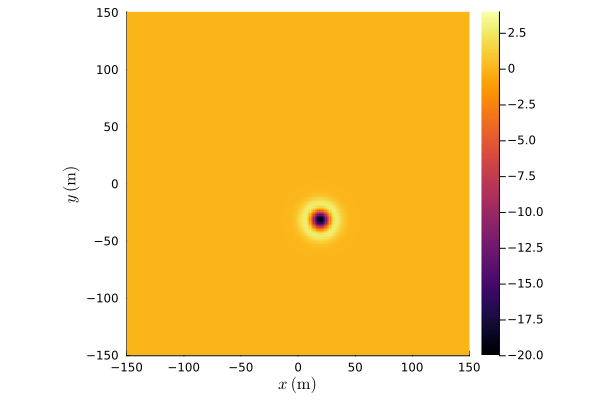

In [4]:
# 3D test wave

# Initial plop
ploplitude = 20.0  # Amplitude of the plop (m)
t0 = t[1]
z0 = zeros(N,N)
Fz0 = dct(z0)
rp2=(xx.-w/(5π)).^2 + (yy.+w/(3π)).^2 # square of radial coord centered on plop
v0 = ploplitude .* (rp2./((w/30)^2).-1) .* exp.(-rp2./((w/30)^2))
Fv0 = dct(v0);

heatmap(x, y, v0, aspect_ratio=1, xlim=(-w/2,w/2), clim=(-ploplitude,ploplitude/5), 
    xlabel=L"$x\ \mathrm{(m)}$", ylabel=L"$y\ \mathrm{(m)}$")

In [5]:
peak_indeces = findmax(abs.(v0))[2]
xip = peak_indeces[1]
yip = peak_indeces[2];

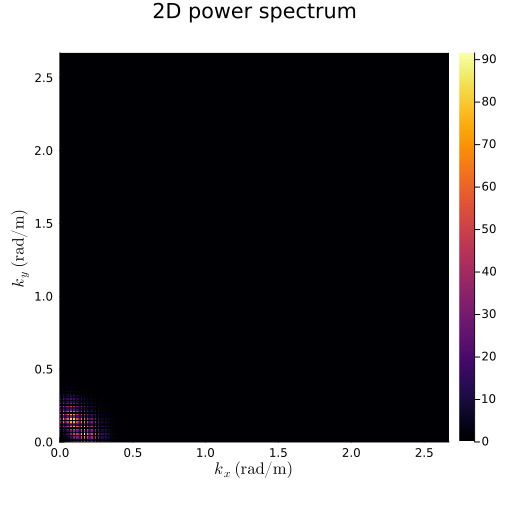

In [6]:
# Calculate & plot the 2D power spectrum
kspectrum2D = kspec2D(Fz0, Fv0)
heatmap(k, k, kspectrum2D, xlabel=L"k_x\ \mathrm{(rad/m)}", ylabel=L"k_y\ \mathrm{(rad/m)}", 
    title="2D power spectrum", aspect_ratio=:equal, size=(512,512),
    xlimits=(0,maximum(k)), ylimits=(0,maximum(k)))

Oops: which_bin = 0
Wavelength at peak = 32.635697593225274 m
Corresponding phase speed = 50.95444073943007 m/s


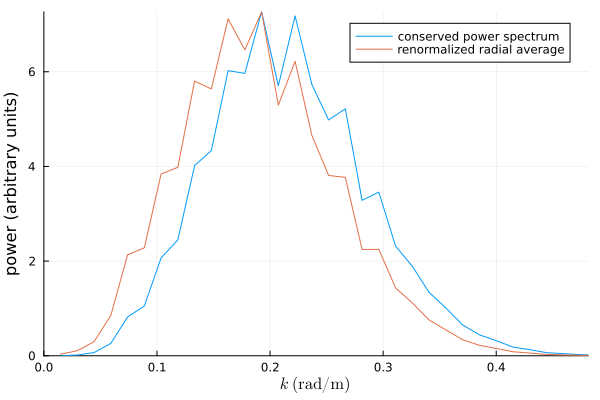

In [7]:
(k1d, powerspec1d) = radial_avg(kspectrum2D, kk)
powerspec_conserved = powerspec1d .* k1d .* (π/2)
(powerspec_conserved_maximum, powerspec_conserved_maximum_index) = findmax(powerspec_conserved)
peak_k = k1d[powerspec_conserved_maximum_index]
peak_wavelength = 2π/peak_k
peak_cp = (g/peak_k) * tanh(peak_k * d)
println("Wavelength at peak = ",peak_wavelength," m")
println("Corresponding phase speed = ",peak_cp," m/s")
powerspec_rad_avg_renorm = powerspec1d/maximum(powerspec1d)*maximum(powerspec_conserved)

myplot = plot(k1d, powerspec_conserved, label="conserved power spectrum")
plot!(k1d, powerspec_rad_avg_renorm, label="renormalized radial average",
    xrange=(0, 2.5*k1d[powerspec_conserved_maximum_index]),
    yrange=(0, powerspec_conserved_maximum),
    xlabel = L"k\ \mathrm{(rad/m)}", ylabel = "power (arbitrary units)")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


 32.104992 seconds (4.34 M allocations: 14.193 GiB, 4.97% gc time, 11.69% compilation time)


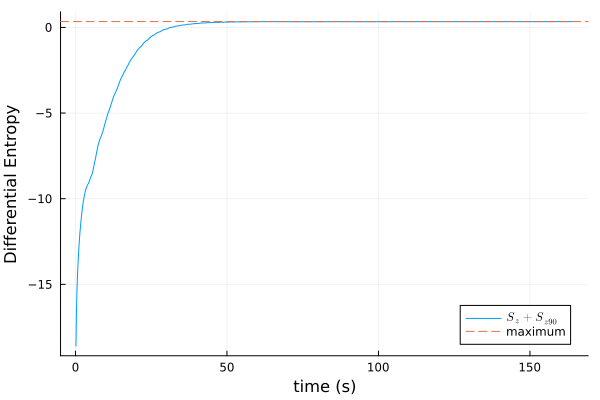

In [8]:
# Work up statistics of the solution, but not keeping solution in memory.
# Determine what should be the plot range. Solving the wave equation
# is quick enough that it doesn't matter I solve the problem more than once
# in the notebook.
plotmin = 0
plotmax = 0
zentropy = zeros(Nt)
ventropy = zeros(Nt)
z90entropy = zeros(Nt)
entropy_estimator = Vasicek(m=N÷2, base=exp(1))
@time @showprogress 1 for i in 1:Nt
    zz,vv,z90 = sea2(Fz0, Fv0, t0, t[i])
    zentropy[i] = entropy(entropy_estimator, vec(zz))
    ventropy[i] = entropy(entropy_estimator, vec(vv))
    z90entropy[i] = entropy(entropy_estimator, vec(z90))
    zzmin = minimum(zz)
    zzmax = maximum(zz)
    if zzmin < plotmin
        plotmin = zzmin
    end
    if zzmax > plotmax
        plotmax = zzmax
    end
end
plotmin *= 1
plotmax *= 1
plot(t, zentropy+z90entropy, label=L"S_z + S_{z90}",
    xlabel="time (s)", ylabel="Differential Entropy")
hline!([maximum(zentropy+z90entropy)], linestyle=:dash, label="maximum")

In [9]:
#Movie

print("0-----------------------------------------------------------------------------------------------100%\n")
flush(stdout)
@time anim = @animate for i in 1:Nt
    zz = sea(Fz0, Fv0, t0, t[i])
    surface(x, y, zz, camera=(40,35),
        xlabel=L"x\ \mathrm{(m)}", ylabel=L"y\ \mathrm{(m)}", zlabel=L"z\ \mathrm{(m)}", 
        zrange=(plotmin,plotmax), color=:ice, colorbar=false, 
        size=(768,768), labelfontsize=18, tickfontsize=12,
        top_margin=-64Plots.mm, bottom_margin=-32Plots.mm,
        left_margin=-16Plots.mm, right_margin=-48Plots.mm) # transparency: seriesalpha=...
    plot!([xx[peak_indeces]],[yy[peak_indeces]],[zz[peak_indeces]], shape=:utriangle, 
        legend=false, seriesalpha=0.75) # a bobber following the plop!
    annotate!(-w/2,0,plotmax,@sprintf("%5.1f s", t[i]), :right)
    if floor(100*i/Nt) > floor(100*(i-1)/Nt)
        print("#")
        flush(stdout)
    end
    if i==Nt
        print('\n')
        flush(stdout)
    end
end

0-----------------------------------------------------------------------------------------------100%
####################################################################################################
135.465479 seconds (11.55 M allocations: 6.499 GiB, 0.95% gc time, 1.77% compilation time: <1% of which was recompilation)


Animation("/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/jl_EvmCjM", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000991.png", "000992.png", "000993.png", "000994.png", "000995.png", "000996.png", "000997.png", "000998.png", "000999.png", "001000.png"])

In [10]:
@time mp4(anim,"Jwaves.mp4",fps=16)

  8.979823 seconds (197.05 k allocations: 13.632 MiB, 0.18% gc time, 5.34% compilation time: 43% of which was recompilation)


[ Info: Saved animation to /Users/kankel/Documents/Personal/FaithAndScience/CCK/ChanceProject/CCK/ChanceSovereignty/Waves/2D-Waves/Jwaves.mp4


Plots.AnimatedGif("/Users/kankel/Documents/Personal/FaithAndScience/CCK/ChanceProject/CCK/ChanceSovereignty/Waves/2D-Waves/Jwaves.mp4")